In [3]:
library(tidyverse)

library(gbm)
library(h2o)
library(xgboost)

In [4]:
ames <- ames <- AmesHousing::make_ames()
index <- sample(1:dim(ames)[1], 0.7*dim(ames)[1])
ames_train <- ames[index,]
ames_test <- ames[-index,]

## GBM(Gradient Boosting Machine)
- 각 트리가 이전 트리를 학습하고 개선하면서 순차적으로 얕은 트리의 앙상블을 구축
- 얕은 나무 자체는 다소 약한 예측 모델이지만 적절하게 조정될 때 효과적

### 부스팅의 원리
- 부스팅은 단순한 모델(결정트리)에서 앙상블을 구축하기 위한 일반적인 알고리즘
- 높은 편향과 낮은 분산을 가진 모델에 더 효과적으로 적용

### 순차 앙상블 접근
- 부스팅의 주요 아이디어는, 새로운 모델을 앙상블에 순차적으로 추가
- 약한모델에서 시작 => 편향-분산-트레이드오프 => 새로운 트리를 구축 => 순차적 성능향상 (이전 트리의 결점을 보완)
- 시퀀스의 각 새로운 트리는 이전 트리에서 가장 큰 예측 오류가 있었던 변수에 초점을 맞춤

<img src = "https://bradleyboehmke.github.io/HOML/images/boosted-trees-process.png">

#### 1. 기본 학습기
- 부스팅은 약한 학습 모델 을 반복적으로 개선하는 프레임워크. 
- 많은 그래디언트 부스팅 응용 프로그램을 사용하면 원하는 대로 다양한 클래스의 약한 학습기를 "플러그인"할 수 있음

#### 2. 약한 모델 훈련
- 약한 모델은 오류율이 무작위 추측보다 약간 더 나은 모델
- 부스팅의 아이디어는 시퀀스의 각 모델이 이전 모델의 성능을 약간 향상시킨다는 것 (기본적으로 이전 트리에서 가장 큰 오류 또는 잔차가 있었던 훈련 데이터의 행에 초점을 맞춤). 
- 결정 트리와 관련하여 얕은 트리(즉, 분할이 상대적으로 적은 트리)는 약한 학습기를 나타냅니다. 부스팅에서는 1-6 분할이 있는 나무가 가장 일반적

#### 3. 오류에 대한 순차 훈련 
- 부스트된 트리는 순차적으로 성장
- 각 트리는 성능을 향상시키기 위해 이전에 성장한 트리의 정보를 사용하여 성장
- 시퀀스의 각 트리를 이전 트리의 잔차에 맞추면, 시퀀스의 각 새 트리가 이전 트리의 실수에 집중할 수 있다.

### 경사하강법
- 경사하강법은 비용함수를 최소화하기 위해 매개변수를 반복적으로 조정
- 경사하강법은 최소값에 도달할 때까지 매개변수를 반복적으로 조정하여 비용 함수(즉, MSE)를 점진적으로 감소시키는 프로세스
<img src = "https://bradleyboehmke.github.io/HOML/10-gradient-boosting_files/figure-html/gradient-descent-fig-1.png">

- 기울기 하강법은 미분 가능한 모든 손실 함수에 대해 수행 가능
- 경사하강법에서 중요한 매개변수는 학습률에 의해 제어되는 step의 크기
- 학습률이 너무 작으면 알고리즘은 최소값을 찾기 위해 많은 반복(단계)을 수행
- 반면에 학습률이 너무 높으면 최소값을 뛰어 넘어 시작했을 때보다 더 멀리 끝날 수 있음

<img src = "https://bradleyboehmke.github.io/HOML/10-gradient-boosting_files/figure-html/learning-rate-fig-1.png">

### 확률적 경사하강법

- 손실 함수의 국소 최소값, 고원 및 기타 불규칙한 지형에서 전역 최소값을 찾는 것을 어려움 
- 확률적 경사하강법은 훈련 관찰의 일부를 비복원추출하고, 해당 하위 샘플을 사용하여 다음 트리를 성장시켜 이 문제를 해결하는 데 도움
- 이것은 알고리즘을 더 빠르게 하지만 랜덤 샘플링의 확률적 특성은, 손실 함수의 기울기를 내림차순으로 약간의 무작위 특성을 추가
- 이 무작위성은 알고리즘이 절대 전역 최소값을 찾는 것을 허용하지 않지만 실제로 알고리즘이 전역 최소값에 충분히 가까워지도록 국소 최소값과 고원에서 벗어나도록 도울 수 있음.


<img src = "https://bradleyboehmke.github.io/HOML/10-gradient-boosting_files/figure-html/stochastic-gradient-descent-fig-1.png">

- **확률적 경사 하강법은 종종 국소 최소값에서 벗어나 고원에서 벗어나 최적에 가까운 솔루션을 찾음**


## 기본 GBM
### 초매개변수

#### 1. 나무의 수
- 시퀀스 또는 앙상블의 총 나무 수
- 배깅과 랜덤 포레스트에서 독립적으로 자란 나무의 평균을 구하면 너무 많은 나무로 과적합하기가 매우 어려움
- GBM은 과거 트리의 실수를 수정하기 위해 각 트리가 순서대로 성장함에 따라 다르게 작동
- GBM은 종종 많은 트리를 필요로 하지만, 쉽게 과적합될 수 있으므로 관심 손실 함수를 최소화하는 최적의 트리 수를 찾아야 함

#### 2. 학습률
- 최종 결과에 대한 각 트리의 기여도를 결정하고 알고리즘이 기울기 하강(학습)을 진행하는 속도를 제어
- 값 범위는 0 ~ 1이고 일반적인 값은 0.001 ~ 0.3
- 값이 작을수록 모델은 각 개별 트리의 특정 변수들에 대해 견고하므로 일반화할 수 있음. 
- 값이 작을수록 과적합 전에 중지하기가 더 쉬움. 그러나 고정된 수의 트리로 최적에 도달하지 못할 위험이 증가하고 더 많은 계산이 필요
- 일반적으로 이 값이 작을수록 모델이 더 정확할 수 있지만 시퀀스에 더 많은 트리가 필요

#### 3. 트리의 깊이 
- 개별 나무의 깊이, 일반적인 값의 범위는 3 ~ 8
- 깊은 트리를 사용하면 알고리즘이 고유한 상호 작용을 캡처할 수 있지만 과적합의 위험도 증가

#### 4. 터미널 노드의 최소 관측값 수 
- 트리의 복잡성을 제어, 일반적인 값의 범위는 5 ~ 15
- 값이 높을수록 모델이 트리에 대해 선택된 특정 샘플에 매우 특정한 관계(과적합)를 학습하는 것을 방지하는 데 도움이 되지만, 작은 값은 분류 문제의 불균형 대상 클래스에 도움이 될 수 있음

### ```gbm::gbm()``` 
- 수식 인터페이스를 사용하여 모델 지정 (Y ~ X)

### ```gbm::gbm.fit()``` 
- 분리된 행렬로 모델 지정 ( y = Y, x = X)
- 더 효율적

#### ```n.trees``` : 나무의 수
#### ```shrinkage``` : 학습률
#### ```interaction.depth``` : 트리의 깊이
#### ```n.minobsinnode``` : 터미널 노드 최소 관측값 수
#### ```cv.folds```
#### ```distribution``` : ```"gaussian"``` = SSE  (squared error), "```"laplace""``` (absolute loss), "```"tdist""``` (t-distribution loss), "```"bernoulli""``` (logistic regression for 0-1 outcomes), "```"huberized""``` (huberized hinge loss for 0-1 outcomes), classes), "```"adaboost""``` (the AdaBoost exponential loss for 0-1 outcomes), "```"poisson""``` (count outcomes), "```"coxph""``` (right censored observations), "```"quantile""```, or "```"pairwise""``` (ranking measure using the LambdaMart algorithm).

In [10]:
set.seed(123) 
ames_gbm1 <- gbm(
  formula = Sale_Price ~ .,
  data = ames_train,
  distribution = "gaussian",  # SSE loss function
  n.trees = 5000,
  shrinkage = 0.1,
  interaction.depth = 3,
  n.minobsinnode = 10,
  cv.folds = 10
)

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."


In [11]:
ames_gbm1

gbm(formula = Sale_Price ~ ., distribution = "gaussian", data = ames_train, 
    n.trees = 5000, interaction.depth = 3, n.minobsinnode = 10, 
    shrinkage = 0.1, cv.folds = 10)
A gradient boosted model with gaussian loss function.
5000 iterations were performed.
The best cross-validation iteration was 1164.
There were 80 predictors of which 76 had non-zero influence.

In [12]:
attributes(ames_gbm1)

$names
 [1] "initF"             "fit"               "train.error"      
 [4] "valid.error"       "oobag.improve"     "trees"            
 [7] "c.splits"          "bag.fraction"      "distribution"     
[10] "interaction.depth" "n.minobsinnode"    "num.classes"      
[13] "n.trees"           "nTrain"            "train.fraction"   
[16] "response.name"     "shrinkage"         "var.levels"       
[19] "var.monotone"      "var.names"         "var.type"         
[22] "verbose"           "data"              "Terms"            
[25] "cv.error"          "cv.folds"          "call"             
[28] "m"                 "cv.fitted"        

$class
[1] "gbm"

In [17]:
ames_gbm1$cv.error %>% length

[1] 5000

#### 최소의 MSE값을 가지는 시퀀스의 RMSE
- 1164개의 나무로 달성된 (교차검증 SSE : 21984)
- 1164번째 시퀀스

In [18]:
best <- which.min(ames_gbm1$cv.error) ; best
sqrt(ames_gbm1$cv.error[best])

[1] 1164

[1] 21984.97

[1] 1164

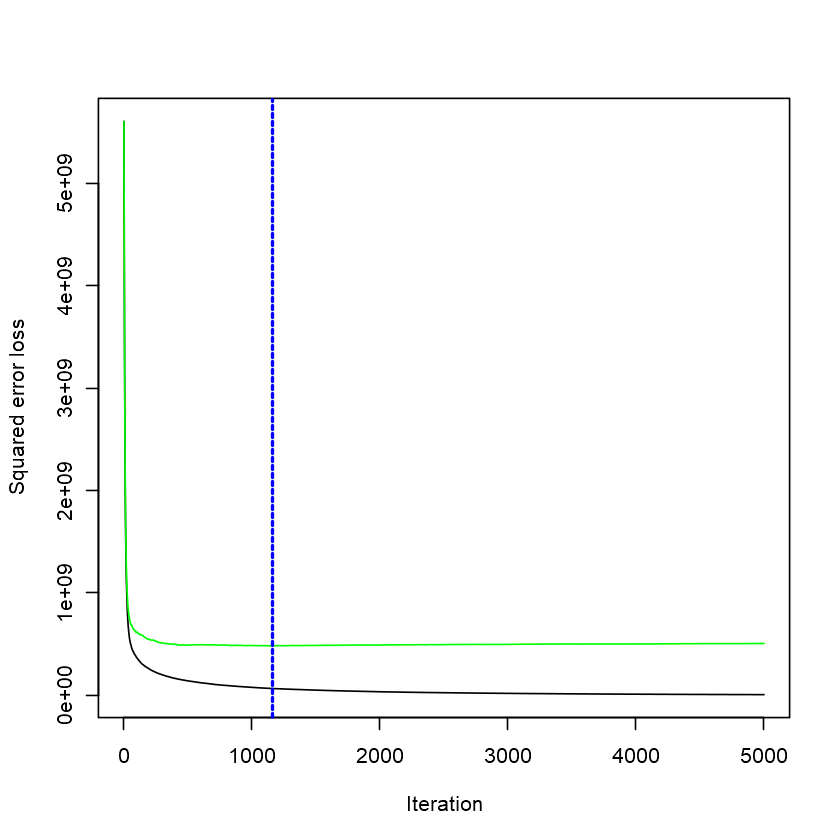

In [20]:
gbm.perf(ames_gbm1, method = "cv")

### 튜닝
- GBM은 초매개변수 설정에 따라 정확도의 변동성이 큼

**1. 상대적으로 높은 학습률을 선택. 일반적으로 기본값 0.1이 작동하지만 0.05 ~ 0.2 사이의 어딘가에서 광범위한 문제에서 작동해야 함.**

**2. 이 학습률에 대한 최적의 트리 수를 결정합니다.**

**3. 트리 초매개변수 (트리의 깊이, 터미널 노드 관측값 수)를 수정하고 학습률을 조정하고 속도 대 성능을 평가.**

**4. 결정된 학습률에 대해 트리별 매개변수를 조정합니다.**

**5. 트리별 매개변수가 발견되면 학습률을 낮추어 정확도 향상을 평가.**

**6. 최종 초매개변수 설정을 사용하고 CV 절차를 통해 강력한 추정치를 탐색. (종종 위의 단계는 계산 제약으로 인해 간단한 검증 절차 또는 5중 CV로 수행.)**

#### - 1-5단계에서 k -fold CV 를 사용한 경우 이 단계가 필요하지 않음.

## 1. 최적의 학습률 탐색

In [24]:
hyper_grid <- expand.grid(
  learning_rate = c(0.3, 0.1, 0.05, 0.01, 0.005),
  RMSE = NA,
  trees = NA,
  time = NA
)
hyper_grid

learning_rate,RMSE,trees,time
<dbl>,<lgl>,<lgl>,<lgl>
0.300,NA,NA,NA
0.100,NA,NA,NA
0.050,NA,NA,NA
0.010,NA,NA,NA
0.005,NA,NA,NA


In [22]:
for(i in seq_len(nrow(hyper_grid))) {
  set.seed(123)  
  train_time <- system.time({
    m <- gbm(
      formula = Sale_Price ~ .,
      data = ames_train,
      distribution = "gaussian",
      n.trees = 5000, 
      shrinkage = hyper_grid$learning_rate[i], 
      interaction.depth = 3, 
      n.minobsinnode = 10,
      cv.folds = 10 
   )
  })
  
  hyper_grid$RMSE[i]  <- sqrt(min(m$cv.error))
  hyper_grid$trees[i] <- which.min(m$cv.error)
  hyper_grid$Time[i]  <- train_time[["elapsed"]]

}

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."


In [23]:
arrange(hyper_grid, RMSE)

learning_rate,RMSE,trees,time,Time
<dbl>,<dbl>,<int>,<lgl>,<dbl>
0.050,21435.55,2280,NA,221.55
0.010,21504.40,4990,NA,217.36
0.100,21984.97,1164,NA,230.68
0.005,22494.79,4994,NA,229.36
0.300,23726.42,631,NA,244.29


#### 최적의 학습률 = 0.05

### 2. 학습률에 대한 최적의 트리 수를 결정
### 3. 트리 초매개변수 (트리의 깊이, 터미널 노드 관측값 수) 결정

In [25]:
hyper_grid <- expand.grid(
  n.trees = 6000,
  shrinkage = 0.01,
  interaction.depth = c(3, 5, 7),
  n.minobsinnode = c(5, 10, 15)
)

In [26]:
model_fit <- function(n.trees, shrinkage, interaction.depth, n.minobsinnode) {
  set.seed(123)
  m <- gbm(
    formula = Sale_Price ~ .,
    data = ames_train,
    distribution = "gaussian",
    n.trees = n.trees,
    shrinkage = shrinkage,
    interaction.depth = interaction.depth,
    n.minobsinnode = n.minobsinnode,
    cv.folds = 10
  )
  # compute RMSE
  sqrt(min(m$cv.error))
}

In [27]:
hyper_grid$rmse <- purrr::pmap_dbl(
  hyper_grid,
  ~ model_fit(
    n.trees = ..1,
    shrinkage = ..2,
    interaction.depth = ..3,
    n.minobsinnode = ..4
    )
)

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."
Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distributi

In [28]:
arrange(hyper_grid, rmse)

n.trees,shrinkage,interaction.depth,n.minobsinnode,rmse
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6000,0.01,7,5,21218.69
6000,0.01,5,10,21256.55
6000,0.01,5,5,21287.74
6000,0.01,3,10,21352.52
6000,0.01,7,10,21445.59
6000,0.01,5,15,21493.72
6000,0.01,7,15,21656.50
6000,0.01,3,5,21729.80
6000,0.01,3,15,21757.75


#### 최적의 초매개변수 : ```n.tree``` = 6000,  ```shrinkage``` = 0.01, ```interaction.depth	``` = 7, ```n.minobsinnode	``` = 5

### 4. 결정된 학습률에 대해 트리별 매개변수를 조정.
### 5. 트리별 매개변수가 발견되면 학습률을 낮추어 정확도 향상을 평가.
### 6. 최종 초매개변수 설정을 사용하고 CV 절차를 통해 강력한 추정치를 탐색. (간단한 검증 절차 또는 5중 CV로 수행.)

#### 최적의 모형

In [69]:
gbm_final <- gbm(
    formula = Sale_Price ~ .,
    data = ames_train,
    distribution = "gaussian",
    n.trees = 6000,
    shrinkage = 0.01,
    interaction.depth = 7,
    n.minobsinnode = 5,
    cv.folds = 5
)

Warning message in gbm.fit(x = x, y = y, offset = offset, distribution = distribution, :
"variable 9: Utilities has no variation."


In [76]:
gbm_final

gbm(formula = Sale_Price ~ ., distribution = "gaussian", data = ames_train, 
    n.trees = 6000, interaction.depth = 7, n.minobsinnode = 5, 
    shrinkage = 0.01, cv.folds = 5)
A gradient boosted model with gaussian loss function.
6000 iterations were performed.
The best cross-validation iteration was 4792.
There were 80 predictors of which 79 had non-zero influence.

#### 모델 평가 시각화
### ```gbm.perf()```
- ```method``` = ```"OOB"```, ```"test"```, ```"cv"```

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



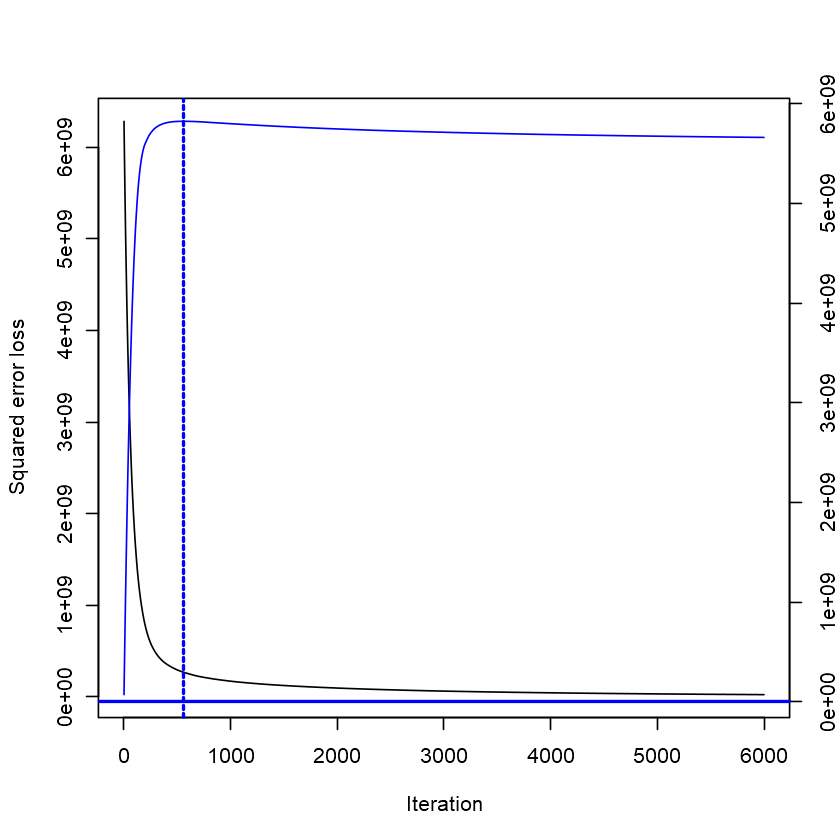

[1] 563
attr(,"smoother")
Call:
loess(formula = object$oobag.improve ~ x, enp.target = min(max(4, 
    length(x)/10), 50))

Number of Observations: 6000 
Equivalent Number of Parameters: 39.99 
Residual Standard Error: 1145000

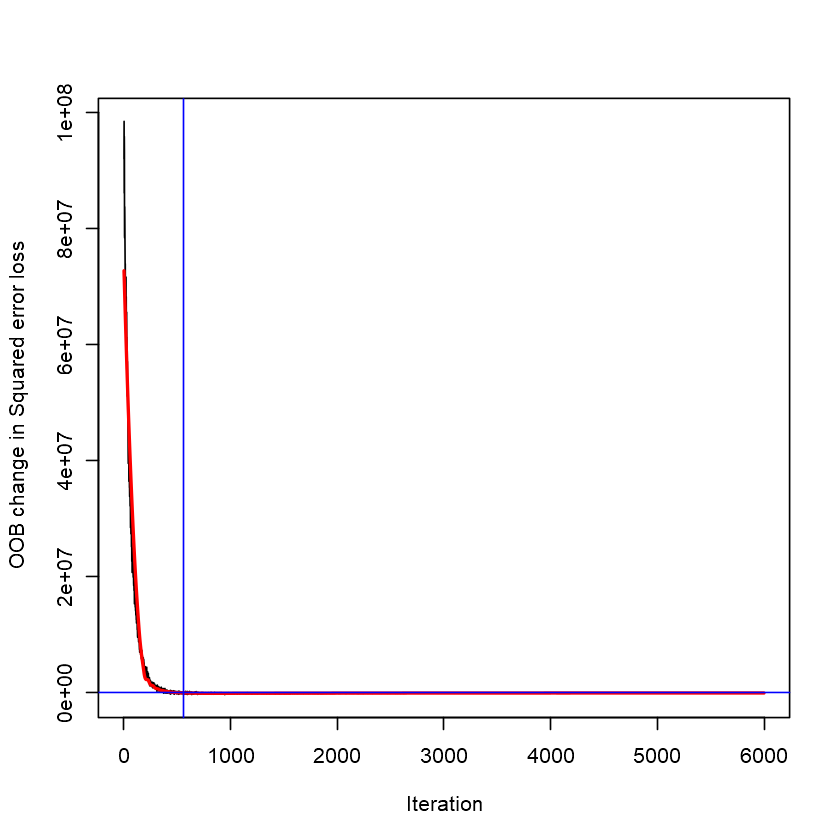

In [75]:
gbm.perf(gbm_final, plot.it = T, oobag.curve = T, method = 'OOB')

### 변수 중요도
### ```summary``` 
- ```method``` = ```ralative.infulence```, ```permutation.test.gbm```

'data.frame':	80 obs. of  2 variables:
 $ var    : chr  "Overall_Qual" "Gr_Liv_Area" "Neighborhood" "Total_Bsmt_SF" ...
 $ rel.inf: num  39.98 12 10.9 4.81 3.67 ...


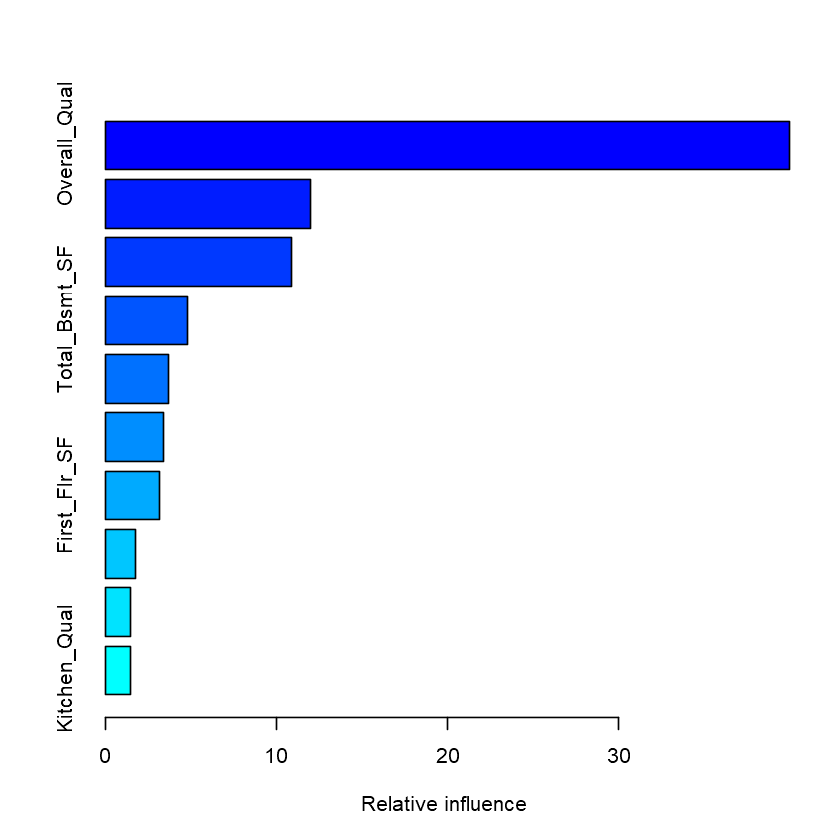

In [74]:
str(summary(
  gbm_final, 
  cBars = 10,
  method = relative.influence, 
))

### 예측

In [77]:
pred <- predict(gbm_final, newdata = ames_test)

Using 4792 trees...




In [78]:
mse <- mean((ames_test$Sale_Price - pred)^2)
rmse <- sqrt(mse)

In [79]:
mse ; rmse

[1] 512261542

[1] 22633.2

## 확률적 GBM (Stochastic  GBM)

### 초매개변수
1. 각 트리를 만들기 전에 행을 재표본추출(gbm,h2o, xgboost 공통)
2. 각 트리를 만들기 전에 열을 재표본추출(h2o, xgboost)
3. 각 트리의 각 분할을 고려하기 전에 열을 재표본추출(h2o, xgboost)

- 훈련 데이터의 50% 이하만 선택하는 것과 같은 공격적인 행 서브샘플링은 유익한 것으로 나타남, 일반적인 값 범위는 0.5 ~ 0.8
- 열의 재표본추출과 성능에 미치는 영향은 데이터의 특성과 강력한 다중 공선성이 있거나 잡음이 많은 기능이 있는지 여부에 크게 좌우

- 랜덤 포레스트의 mtr 매개변수와 유사하게 상관관계가 있는 변수들이 적은 경우(혹은 노이즈) 열 재표본추출의 값이 높을수록, 신호가 가장 강한 특성을 선택할 가능성이 더 높기 때문에 성능이 더 좋은 경향이 있다. 
- 상관관계가 있는 변수가 많은 경우, 열 재표본추출 값이 낮을수록 성능이 좋은 경향이 있다.

### h2o

In [4]:
h2o.no_progress()
h2o.init(max_mem_size = "10g")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\APF_TE~1\AppData\Local\Temp\RtmpMNNEhz\file369432940ac/h2o_apf_temp_admin_started_from_r.out
    C:\Users\APF_TE~1\AppData\Local\Temp\RtmpMNNEhz\file36944ec6559/h2o_apf_temp_admin_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         15 seconds 100 milliseconds 
    H2O cluster timezone:       Asia/Seoul 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.4 
    H2O cluster version age:    7 days, 11 hours and 2 minutes  
    H2O cluster name:           H2O_started_from_R_apf_temp_admin_ohi942 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   8.88 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 

In [5]:
train_h2o <- as.h2o(ames_train)
test_h2o <- as.h2o(ames_test)

In [6]:
response <- "Sale_Price"
predictors <- setdiff(colnames(ames_train), response)

In [7]:
hyper_grid <- list(
  sample_rate = c(0.5, 0.75, 1),              # 행 재표본추출 비율
  col_sample_rate = c(0.5, 0.75, 1),          # 각 분할마다 열 재표본추출 비율
  col_sample_rate_per_tree = c(0.5, 0.75, 1)  # 각 나무마다 열 재표본추출 비율
)

#### 그리드서치의 조기종료 옵션

In [8]:
search_criteria <- list(
  strategy = "RandomDiscrete",
  stopping_metric = "mse",
  stopping_tolerance = 0.001,   
  stopping_rounds = 10,         
  max_runtime_secs = 60*10      
)

In [ ]:
grid <- h2o.grid(
  algorithm = "gbm",
  grid_id = "gbm_grid",
  x = predictors, 
  y = response,
  training_frame = train_h2o,
  hyper_params = hyper_grid,
  ntrees = 6000, # 나무의 수
  learn_rate = 0.01, # 학습률
  max_depth = 7, # 트리의 깊이
  min_rows = 5, # 터미널 노드 최소 관측값 수
  nfolds = 10,
  stopping_rounds = 10,
  stopping_tolerance = 0,
  search_criteria = search_criteria, # 그리드서치의 조기종료 옵션
  seed = 123
)

In [ ]:
grid_perf <- h2o.getGrid(
  grid_id = "gbm_grid", 
  sort_by = "mse", 
  decreasing = FALSE
)
grid_perf

```
H2O Grid Details
================

Grid ID: gbm_grid 
Used hyper parameters: 
  -  col_sample_rate 
  -  col_sample_rate_per_tree 
  -  sample_rate 
Number of models: 3 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing mse
  col_sample_rate col_sample_rate_per_tree sample_rate
1         0.50000                  0.50000     1.00000
2         0.75000                  0.75000     0.50000
3         1.00000                  0.75000     0.50000
         model_ids              mse
1 gbm_grid_model_1  486950528.27502
2 gbm_grid_model_2 4589623927.78911
3 gbm_grid_model_3 6127075830.59810
```

In [ ]:
grid_perf@summary_table %>% head

```
Hyper-Parameter Search Summary: ordered by increasing mse
  col_sample_rate col_sample_rate_per_tree sample_rate
1         0.50000                  0.50000     1.00000
2         0.75000                  0.75000     0.50000
3         1.00000                  0.75000     0.50000
         model_ids              mse
1 gbm_grid_model_1  486950528.27502
2 gbm_grid_model_2 4589623927.78911
3 gbm_grid_model_3 6127075830.59810
```

#### 최적의 모델

In [ ]:
best_model_id <- grid_perf@model_ids[[1]]
best_model <- h2o.getModel(best_model_id)

#### 모델 평가

In [ ]:
h2o.performance(model = best_model, xval = TRUE)

```
H2ORegressionMetrics: gbm
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  486950528
RMSE:  22066.96
MAE:  13147.63
RMSLE:  0.116763
Mean Residual Deviance :  486950528
```

#### 변수 중요도
### ```h2o.varimp()```

In [ ]:
h2o.varimp(best_model)

In [25]:
vip::vip(best_model)

ERROR: Error in vip::vip(best_model): object 'best_model' not found


### 예측

In [ ]:
perf <- h2o.performance(model = best_model, newdata = test_h2o)
perf

```
H2ORegressionMetrics: gbm

MSE:  477428821
RMSE:  21850.14
MAE:  14250.68
RMSLE:  0.1332685
Mean Residual Deviance :  477428821
```

In [ ]:
h2o.r2(perf)

[1] 0.9250505

## XGBoost
- 여러 언어에서 효율적이고 유연하며 이식 가능하도록 설계된 최적화된 분산 그래디언트 부스팅 라이브러리
- 기존 부스팅에 비해 몇 가지 이점
1. 정규화 : XGBoost는 과적합에 대한 추가 보호를 제공하는 추가 정규화 하이퍼파라미터를 제공
2. 조기 중지 : h2o 와 유사하게 XGBoost는 조기 중지를 구현하여 추가 트리가 개선되지 않을 때 모델 평가를 중지할 수 있음
3. 병렬 처리 : 그래디언트 부스팅은 본질적으로 순차적이기 때문에 병렬화하기가 매우 어렵습니다. XGBoost는 GPU 및 Spark 호환성을 지원하는 절차를 구현하여 강력한 분산 처리 엔진을 사용하여 그래디언트 부스팅을 맞출 수 있음
4. 손실 함수 : XGBoost를 사용하면 사용자 정의 목표 및 평가 기준을 사용하여 그래디언트 부스팅 모델을 정의하고 최적화할 수 있음
5. 기존 모델로 계속 : 사용자는 XGBoost 모델을 훈련하고 결과를 저장하고 나중에 해당 모델로 돌아가 결과를 계속 구축할 수 있음
6. 다른 학습기 유형 : 대부분의 GBM 구현은 의사결정 트리로 구축되지만 XGBoost는 또한 부스트 일반화 선형 모델도 제공
7. 다중 언어 : XGBoost는 R, Python, Julia, Scala, Java 및 C++로 구현을 제공

### 초매개변수

### 1. 정규화
- 모델 복잡성을 줄이고 과적합을 방지하는 데 도움이 되는 여러 정규화 매개변수를 제공
### ```gamma``` 
- ```gamma```는 Lagrangian 승수로 알려진 의사 정규화 하이퍼파라미터이며 주어진 트리의 복잡성을 제어
- ```gamma```는 트리의 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소를 지정
- 범위 : 0 ~ Inf, 손실 함수에 따라 다르지만 일반적으로 1~20 사이의 낮은 값
### ```alpha``` & ```lambda```
- ```gamma```와 ```alpha``` 모두 0보다 크게 설정하면 Elastic Net
- 범위 : 0 ~ Inf

- (```gamma```, ```alpha```, ```lambda```)는 모두 모델 복잡성을 제한하고 과적합을 줄이는 데 사용

### 2. 드롭아웃
- 드롭아웃은 과적합을 줄이기 위한 대안적 접근 방식 (정규화와 유사)
- GBM을 구성할 때 앙상블의 시작 부분에 추가된 처음 몇 개의 트리는 일반적으로 모델 성능을 지배하는 반면, 나중에 추가된 트리는 일반적으로 변수들의 작은 하위 집합에 대한 예측을 향상, **이것은 종종 과적합의 위험을 증가**
- 드롭아웃의 아이디어는 부스팅 시퀀스에서 무작위로 트리를 드롭하여 앙상블을 구축하는 것

### 튜닝
1. 조기 중지로 트리 수를 늘리고 학습률을 조정.
2. 트리별 하이퍼파라미터 조정
3. 확률적 GBM 속성 탐색
4. 과적합이 발생하는 경우(예: 훈련오차와 CV 오차 간의 차이) 정규화 하이퍼파라미터 탐색
5. 기본 설정과 상당히 다른 초매개변수 값을 찾으면 학습률을 다시 조정.
7. 최종 "최적" 모델 획득

### XGBoost 데이터 준비
- xgboost 는 변수에 대한 행렬 입력이 필요하고 응답은 벡터
- 결과적으로 변수의 행렬 입력을 제공하려면 범주형 변수를 숫자로 인코딩 (원-핫 인코딩, 레이블 인코딩). 

### - 모든 범주형 변수들을 수치형 레이블로 인코딩하고, 훈련 데이터 프레임을 행렬로 변환.

In [6]:
library(recipes)
xgb_trprep <- recipe(Sale_Price ~ ., data = ames_train) %>%
  step_integer(all_nominal()) %>%
  prep(training = ames_train, retain = TRUE) %>%
  juice()

xgb_tsprep <- recipe(Sale_Price ~ ., data = ames_test) %>%
  step_integer(all_nominal()) %>%
  prep(training = ames_test, retain = TRUE) %>%
  juice()

### ```xgb.DMatrix()```

In [7]:
X_train <- as.matrix(xgb_trprep[setdiff(names(xgb_trprep), "Sale_Price")])
Y_train <- xgb_trprep$Sale_Price

X_test <- as.matrix(xgb_tsprep[setdiff(names(xgb_tsprep), "Sale_Price")])
Y_test <- xgb_tsprep$Sale_Price

In [9]:
dtrain <- xgb.DMatrix(data = X_train, label = Y_train)
dtest <- xgb.DMatrix(data = X_test, label = Y_test)

### ```xgb.cv()```
- ```objective``` : ```reg:linear``` (선형회귀), ```binary:logistic``` (이진분류), ```multi:softmax``` (다지분류)

In [10]:
set.seed(123)
ames_xgb <- xgb.cv(
  data = dtrain,
  nrounds = 6000,
  objective = "reg:linear",
  early_stopping_rounds = 50, 
  nfold = 10,
  params = list(
    eta = 0.1, 
    max_depth = 3, 
    min_child_weight = 3, 
    subsample = 0.8,
    colsample_bytree = 1.0),
  verbose = 0
)  

[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:34] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg

In [22]:
attributes(ames_xgb)

$names
[1] "call"            "params"          "callbacks"       "evaluation_log" 
[5] "niter"           "nfeatures"       "folds"           "best_iteration" 
[9] "best_ntreelimit"

$class
[1] "xgb.cv.synchronous"

In [21]:
ames_xgb$evaluation_log %>% arrange(test_rmse_mean) %>% head

iter,train_rmse_mean,train_rmse_std,test_rmse_mean,test_rmse_std
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
587,6798.699,89.26837,22415.22,4872.597
595,6731.014,93.92283,22415.54,4879.457
585,6817.408,89.08092,22416.37,4870.623
594,6738.205,93.89295,22417.16,4880.208
596,6721.908,93.01846,22417.19,4877.538
588,6789.242,89.88376,22417.96,4869.480


### 그리드서치
- 과적합이 모델의 성능을 제한하는지 평가

In [23]:
hyper_grid <- expand.grid(
  eta = 0.1, # 학습율
  max_depth = 3, # 트리의 깊이
  min_child_weight = 3, # 터미널 노드 최소 관측값 수 
  subsample = 0.5,  # 행 재표본추출 비율
  colsample_bytree = 0.5, # 각 나무마다 열 재표본추출 비율
  gamma = c(0, 1, 10, 100, 1000),
  lambda = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  alpha = c(0, 1e-2, 0.1, 1, 100, 1000, 10000),
  rmse = 0,          
  trees = 0          
)

In [ ]:
for(i in seq_len(nrow(hyper_grid))) {
  set.seed(123)
  m <- xgb.cv(
    data = dtrain,
    nrounds = 4000,
    objective = "reg:linear",
    early_stopping_rounds = 50, 
    nfold = 10,
    verbose = 0,
    params = list( 
      eta = hyper_grid$eta[i], 
      max_depth = hyper_grid$max_depth[i],
      min_child_weight = hyper_grid$min_child_weight[i],
      subsample = hyper_grid$subsample[i],
      colsample_bytree = hyper_grid$colsample_bytree[i],
      gamma = hyper_grid$gamma[i], 
      lambda = hyper_grid$lambda[i], 
      alpha = hyper_grid$alpha[i]
    ) 
  )
  hyper_grid$rmse[i] <- min(m$evaluation_log$test_rmse_mean)
  hyper_grid$trees[i] <- m$best_iteration
}

In [26]:
hyper_grid %>%
  filter(rmse > 0) %>%
  arrange(rmse) %>% head

,eta,max_depth,min_child_weight,subsample,colsample_bytree,gamma,lambda,alpha,rmse,trees
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1,3,3,0.5,0.5,1,100,100.0,21909.91,978
2,0.1,3,3,0.5,0.5,0,100,100.0,21909.91,978
3,0.1,3,3,0.5,0.5,10,100,100.0,21909.91,978
4,0.1,3,3,0.5,0.5,100,100,100.0,21909.91,978
5,0.1,3,3,0.5,0.5,1000,100,100.0,21909.91,978
6,0.1,3,3,0.5,0.5,0,100,0.1,21938.10,1011


#### 최적의 초매개변수 
- ```eta``` = 0.1, ```max_depth``` = 3, ```min_child_weight``` = 3, ```subsample``` = 0.5, ```colsample_bytree``` = 0.5`, ```gamma``` = 1, ```lambda``` = 100, ```alpha``` = 100, ```nrounds``` = 978

In [34]:
params <- list(
  eta = 0.1,
  max_depth = 3,
  min_child_weight = 3,
  subsample = 0.5,
  colsample_bytree = 0.5,
  gamma = 1,
  lambda = 100,
  alpha = 100
)

In [35]:
xgb.fit.final <- xgboost(
  params = params,
  dtrain,
  nrounds = 978,
  objective = "reg:linear",
  verbose = 0
)

[17:22:28] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [39]:
attributes(xgb.fit.final)

$names
[1] "handle"         "raw"            "niter"          "evaluation_log"
[5] "call"           "params"         "callbacks"      "feature_names" 
[9] "nfeatures"     

$class
[1] "xgb.Booster"

### 변수 중요도
### ```xgb.importance()``` 
- 변수 중요도 행렬

### ```xgb.ggplot.importance()```

In [81]:
imp <- xgb.importance(model = xgb.fit.final) %>% arrange(desc(Gain))
head(imp)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
Overall_Qual,0.24232202,0.048219193,0.032110092
Gr_Liv_Area,0.21833439,0.071477949,0.059158494
Total_Bsmt_SF,0.05798422,0.070694535,0.053622271
First_Flr_SF,0.04000017,0.055797649,0.051407782
Garage_Area,0.03716736,0.042604780,0.039228092
Garage_Cars,0.03629188,0.004372032,0.004112623


Warning message in `[.data.table`(importance_matrix, , `:=`(Importance, sum(get(measure))), :
"Invalid .internal.selfref detected and fixed by taking a (shallow) copy of the data.table so that := can add this new column by reference. At an earlier point, this data.table has been copied by R (or was created manually using structure() or similar). Avoid names<- and attr<- which in R currently (and oddly) may copy the whole data.table. Use set* syntax instead to avoid copying: ?set, ?setnames and ?setattr. If this message doesn't help, please report your use case to the data.table issue tracker so the root cause can be fixed or this message improved."


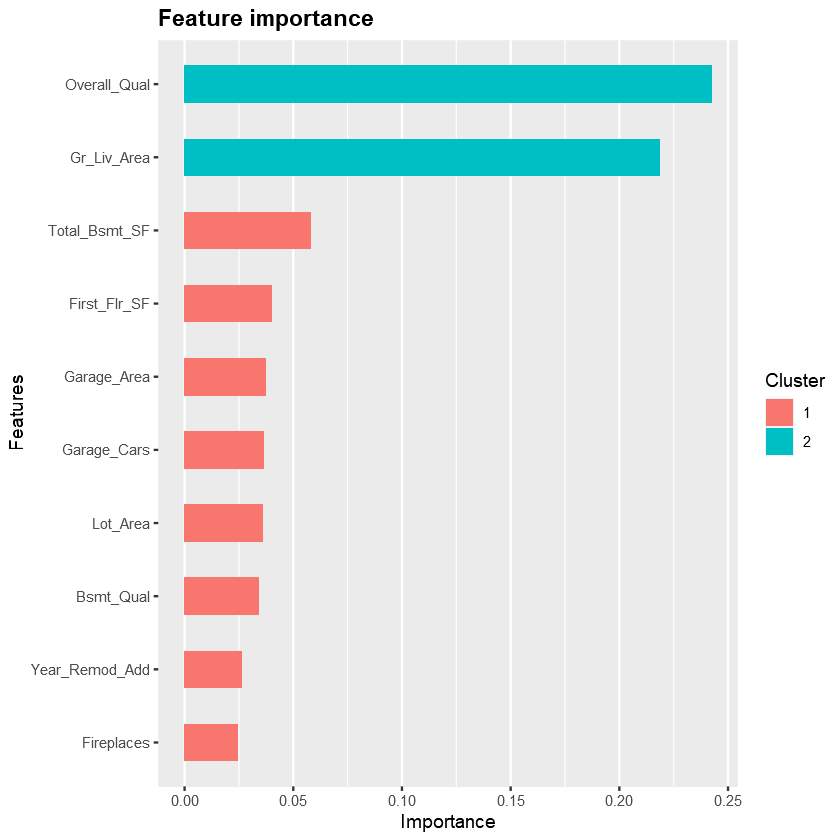

In [108]:
xgboost::xgb.ggplot.importance(importance_matrix = imp, top_n = 10)

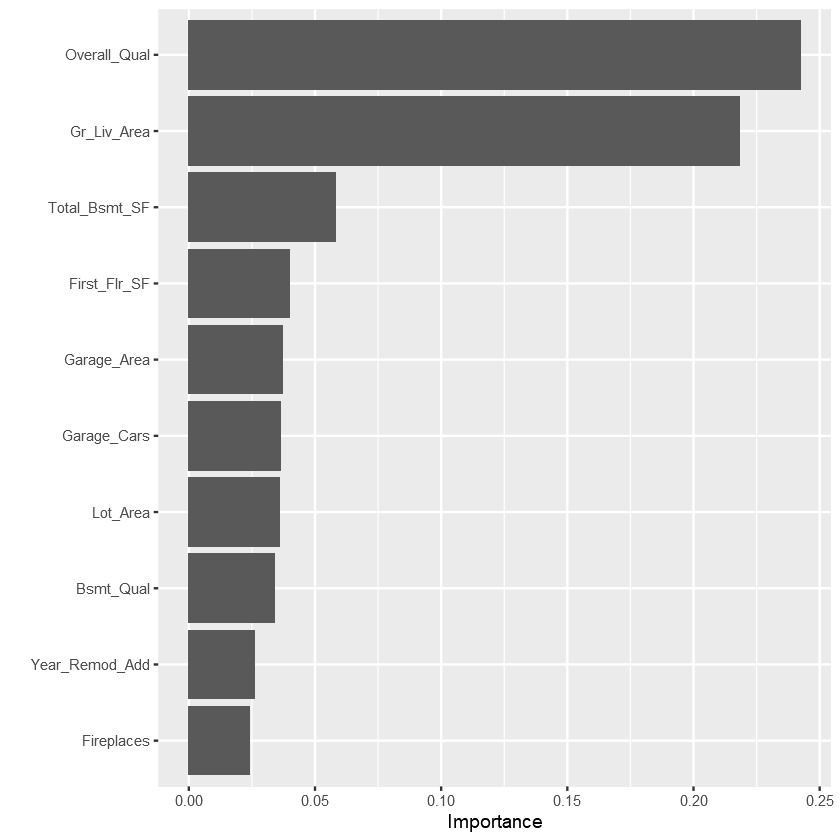

In [95]:
vip::vip(xgb.fit.final)

### 예측

In [109]:
pred <- predict(xgb.fit.final, newdata = dtest)

In [110]:
mse = mean((Y_test - pred)^2)
rmse = sqrt(mse)

In [111]:
mse ; rmse

[1] 641601978

[1] 25329.86

### Save & Load
### ```xgb.save()```

In [112]:
xgb.save(xgb.fit.final, "xgboost.model")

[1] TRUE

In [113]:
xgb.fit.final2 <- xgb.load("xgboost.model")

[17:55:11] WARNING: amalgamation/../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


In [114]:
xgb.fit.final2

##### xgb.Booster
raw: 1 Mb 
xgb.attributes:
  niter
niter: 977

In [115]:
pred2 <- predict(xgb.fit.final2, newdata= dtest)

In [116]:
mse2 = mean((Y_test - pred2)^2)
rmse2 = sqrt(mse)
mse2 ; rmse2

[1] 641601978

[1] 25329.86